# Stability Analysis of rate controller

## Helper functions

In [1]:
import math
import pydot
import matplotlib.pyplot as plt
import mpld3
import numpy as np
from IPython.display import HTML, display, SVG
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    ControllabilityMatrix,
    DiagramBuilder,
    Linearize,
    LinearQuadraticRegulator,
    MeshcatVisualizer,
    MultibodyPlant,
    Parser,
    Propeller,
    PropellerInfo,
    RigidTransform,
    RobotDiagramBuilder,
    Saturation,
    SceneGraph,
    Simulator,
    StartMeshcat,
    WrapToSystem,
    namedview,
)
from pydrake.examples import (
    AcrobotGeometry,
    AcrobotInput,
    AcrobotPlant,
    AcrobotState,
    QuadrotorGeometry,
    QuadrotorPlant,
    StabilizingLQRController,
)
from pydrake.solvers import MathematicalProgram, Solve
import os
from underactuated import ConfigureParser, running_as_notebook
from underactuated.meshcat_utils import MeshcatSliders
from underactuated.quadrotor2d import Quadrotor2D, Quadrotor2DVisualizer
from underactuated.scenarios import AddFloatingRpyJoint
from pydrake.multibody.tree import QuaternionFloatingJoint
if running_as_notebook:
    mpld3.enable_notebook()

meshcat = StartMeshcat()


def MakeMultibodyQuadrotor():
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.0)
    #plant = builder.AddSystem(MultibodyPlant(0.0))
    #scene_graph = builder.AddSystem(SceneGraph())
    parser = Parser(plant)
    
    # Your relative path
    relative_path = "quad-v4/quad-v4.urdf"
    # Convert to an absolute path
    absolute_path = os.path.abspath(relative_path)
    
    # Use the absolute path here
    (model_instance,) = parser.AddModels(absolute_path)
    
    # Adding QuaternionFloatingJoint
    frame_on_parent = plant.world_frame()
    frame_on_child = plant.GetFrameByName("quad_v4", model_instance)
    plant.AddJoint(
        QuaternionFloatingJoint(
            name="BaseJoint",
            frame_on_parent=frame_on_parent,  # Corrected parameter name
            frame_on_child=frame_on_child,  # Corrected parameter name
            angular_damping=0.0,  # Optional, showing how to use it
            translational_damping=0.0  # Optional, showing how to use it
        )
    )
    plant.Finalize()

    visualizer = MeshcatVisualizer.AddToBuilder(
        builder, scene_graph, meshcat
    )

    body_index = plant.GetBodyByName("quad_v4").index()

    L = 0.395 #meters arm length
    #prop_offsets = [0.21507, 0.27856, 0.09495]
    prop_pos = {'x' : 0.21507, 'y' : 0.27856, 'z' : 0.09495}
    kF = 6.5 #0.77 #estimate thrust constant (thrust = kF * angularvelocity^2)
    kM = 0.05 #estimate torque constant (torque = kM * angularvelocity^2)

    """
    prop_info = [
        PropellerInfo(body_index, RigidTransform([L, 0, 0]), kF, kM),
        PropellerInfo(body_index, RigidTransform([0, L, 0]), kF, -kM),
        PropellerInfo(body_index, RigidTransform([-L, 0, 0]), kF, kM),
        PropellerInfo(body_index, RigidTransform([0, -L, 0]), kF, -kM),
    ]
    """

    prop_info = [
        PropellerInfo(body_index, RigidTransform([-prop_pos['x'], -prop_pos['y'], prop_pos['z']]), kF, kM), #CW
        PropellerInfo(body_index, RigidTransform([prop_pos['x'], -prop_pos['y'], prop_pos['z']]), kF, -kM), #CCW
        PropellerInfo(body_index, RigidTransform([prop_pos['x'], prop_pos['y'], prop_pos['z']]), kF, kM), #CW
        PropellerInfo(body_index, RigidTransform([-prop_pos['x'], prop_pos['y'], prop_pos['z']]), kF, -kM), #CCW
    ]
    propellers = builder.AddSystem(Propeller(prop_info))
    builder.Connect(
        propellers.get_output_port(),
        plant.get_applied_spatial_force_input_port(),
    )
    builder.Connect(
        plant.get_body_poses_output_port(),
        propellers.get_body_poses_input_port(),
    )

    #quad_base = plant.GetModelInstanceByName("body")
    builder.ExportInput(propellers.get_command_input_port(), "u")
    builder.ExportOutput(plant.get_state_output_port(), "state")


    return builder.Build(), plant

def matrix_to_latex(matrix, name="A"):
    """Convert a NumPy matrix to a LaTeX representation."""
    latex_str = f"{name} = \\begin{{bmatrix}}"
    for i in range(matrix.shape[0]):
        row_str = " & ".join(f"{matrix[i, j]:.4f}" for j in range(matrix.shape[1]))
        latex_str += row_str
        if i < matrix.shape[0] - 1:
            latex_str += "\\\\"
    latex_str += "\\end{bmatrix}"
    return latex_str

INFO:drake:Meshcat listening for connections at http://localhost:7000


## Import 2024 UAVF Comp Quad 

In [2]:

quadrotor_system, quadrotor_plant = MakeMultibodyQuadrotor()

quadrotor_plant.set_name("quadrotor_base")

quadrotor_system.set_name("quadrotor_system")

### Print Port information

In [3]:
# Print information about input ports
print("Input Ports (Thrust commands)")
print(f"N input ports : {quadrotor_system.num_input_ports()}")
print(f"Actuation port size {quadrotor_system.get_input_port(0).size()} [u_1, u_2, u_3, u_4] for thrust produced by each prop")

prefix_to_filter = "quad-v4_BaseJoint_"

original_state_names = quadrotor_plant.GetStateNames()
filtered_state_names = [name.removeprefix(prefix_to_filter) for name in original_state_names]
states = filtered_state_names

# Print information about output ports
print("\nOutput Ports:")
print(f"N output ports : {quadrotor_system.num_input_ports()}")
print(f"State vector port size {quadrotor_system.get_output_port(0).size()} {states} for state vector of position velocity attitude and angular rates")

Input Ports (Thrust commands)
N input ports : 1
Actuation port size 4 [u_1, u_2, u_3, u_4] for thrust produced by each prop

Output Ports:
N output ports : 1
State vector port size 13 ['qw', 'qx', 'qy', 'qz', 'x', 'y', 'z', 'wx', 'wy', 'wz', 'vx', 'vy', 'vz'] for state vector of position velocity attitude and angular rates


### Linearize Dynamics about approximate hover

In [4]:
from pydrake.all import (
    DiagramBuilder,
    LinearQuadraticRegulator,
    FirstOrderTaylorApproximation,
    Simulator,
)

# Create a context for the entire quadrotor_system (Diagram), not just the plant
quadrotor_system_context = quadrotor_system.CreateDefaultContext()

# Now, use the diagram context to get the plant context
quadrotor_plant_context = quadrotor_system.GetMutableSubsystemContext(quadrotor_plant, quadrotor_system_context)

# Set the plant's state to the hover state in the plant's context
hover_state = np.array([1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])  # Hovering at z=1m, level orientation, no velocity
quadrotor_plant.SetPositionsAndVelocities(quadrotor_plant_context, hover_state)

# Fix the value of the input port on the diagram context, not the plant context
input_port = quadrotor_system.get_input_port(0)
# Calculate nominal input
mass = quadrotor_plant.CalcTotalMass(quadrotor_plant.GetMyContextFromRoot(quadrotor_system_context))
gravity = quadrotor_plant.gravity_field().gravity_vector()
nominal_input = [(-mass * gravity[2]) / 4] * 4

input_port.FixValue(quadrotor_system_context, nominal_input)

# Proceed with the first-order Taylor approximation using the diagram context
approximation = FirstOrderTaylorApproximation(
    system=quadrotor_system,
    context=quadrotor_system_context,
    input_port_index=input_port.get_index(),
    output_port_index=quadrotor_system.get_output_port(0).get_index()
)

A = approximation.A()
B = approximation.B()
C = approximation.C()
D = approximation.D()


### State Space Matricies

In [5]:
from IPython.display import display, Latex

# Assuming A_matrix and B_matrix are already defined as the A and B matrices from your linear system

# Convert matrices to LaTeX strings
A_latex = matrix_to_latex(A, "A")
B_latex = matrix_to_latex(B, "B")
C_latex = matrix_to_latex(C, "C")
D_latex = matrix_to_latex(D, "D")

# Display matrices in LaTeX format
display(Latex(A_latex))
display(Latex(B_latex))
display(Latex(C_latex))
display(Latex(D_latex))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Thrust allocation Matrix

In [19]:
import slycot
import control as ctrl


degrees = 49.57
beta = np.deg2rad(degrees)
c_t = 1  # Example value for c
c_q = 1
l = 0.39 #meters
# Define the thrust allocation matrix G1
#G1 = np.array([[1, 1, 1, 1],
#               [-np.sin(beta), np.cos(beta), np.sin(beta), -np.cos(beta)],
#               [np.cos(beta), np.sin(beta), -np.cos(beta), -np.sin(beta)],
#               [1/c, -1/c, 1/c, -1/c]])

G1 = np.array([[1, 1, 1, 1],
               [l*np.sin(beta), -l*np.sin(beta), -l*np.sin(beta), l*np.sin(beta)],
               [-l*np.cos(beta), -l*np.cos(beta), l*np.cos(beta), l*np.cos(beta)],
               [c_q / c_t, -c_q / c_t, c_q / c_t, -c_q / c_t]])

## Dynamics Transfer Function & PID Transfer Function

In [20]:
# Invert G1
G1_inv = np.linalg.inv(G1)
# Create the state-space model
state_space_model = ctrl.StateSpace(A, (B @ G1_inv), C, D)


# Convert state space model to transfer function
G = ctrl.ss2tf(state_space_model)

print(f"State transfer function has n inputs {G.ninputs}")
print(f"State Transfer function has n outputs {G.noutputs}")

# Define PID parameters for roll, pitch, and yaw
Kp_roll, Ki_roll, Kd_roll = 0.15000000596046448, 0.20000000298023224, 0.003000000026077032
Kp_pitch, Ki_pitch, Kd_pitch = 0.2000000596046448, 0.10000000298023224, 0.005000000026077032
Kp_yaw, Ki_yaw, Kd_yaw = 0.20000000298023224, 0.10000000149011612, 0.003

# Create the PID controllers for each axis
s = ctrl.TransferFunction.s
pid_roll = Kp_roll + Ki_roll/s + Kd_roll*s
pid_pitch = Kp_pitch + Ki_pitch/s + Kd_pitch*s
pid_yaw = Kp_yaw + Ki_yaw/s + Kd_yaw*s


print(f"Roll rate transfer")
print(pid_roll)
print()
print(f"Pitch rate transfer")
print(pid_pitch)
print()
print(f"Yaw rate transfer")
print(pid_yaw)
print()

print(f"Roll rate PID transfer function has n inputs {pid_roll.ninputs}")
print(f"pitch rate PID transfer function has n inputs{pid_pitch.ninputs}")
print(f"yaw rate PID transfer function has n inputs {pid_yaw.ninputs}")

print(f"Roll rate PID transfer function has n outputs {pid_roll.noutputs}")
print(f"pitch rate PID transfer function has n outputs{pid_pitch.noutputs}")
print(f"yaw rate PID transfer function has n outputs {pid_yaw.noutputs}")

State transfer function has n inputs 4
State Transfer function has n outputs 13
Roll rate transfer

0.003 s^2 + 0.15 s + 0.2
------------------------
           s


Pitch rate transfer

0.005 s^2 + 0.2 s + 0.1
-----------------------
           s


Yaw rate transfer

0.003 s^2 + 0.2 s + 0.1
-----------------------
           s


Roll rate PID transfer function has n inputs 1
pitch rate PID transfer function has n inputs1
yaw rate PID transfer function has n inputs 1
Roll rate PID transfer function has n outputs 1
pitch rate PID transfer function has n outputs1
yaw rate PID transfer function has n outputs 1


### PID Transfer function

In [24]:
# Define PID parameters for roll, pitch, and yaw
Kp_roll, Ki_roll, Kd_roll = 0.15000000596046448, 0.20000000298023224, 0.003000000026077032
Kp_pitch, Ki_pitch, Kd_pitch = 0.2000000596046448, 0.10000000298023224, 0.005000000026077032
Kp_yaw, Ki_yaw, Kd_yaw = 0.20000000298023224, 0.10000000149011612, 0

# Create the PID controllers for each axis
s = ctrl.TransferFunction.s
pid_roll = Kp_roll + Ki_roll/s + Kd_roll*s
pid_pitch = Kp_pitch + Ki_pitch/s + Kd_pitch*s
pid_yaw = Kp_yaw + Ki_yaw/s + Kd_yaw*s

# Since the B_matrix likely has different columns for different inputs (torques for each axis),
# You need to define a transfer function from the state space model for each input axis.
# For example:
G_roll = G[7, 0]  # First output, first input
G_pitch = G[8, 1]  # First output, second input
G_yaw = G[9, 2]  # First output, third input

# Calculate the closed-loop transfer functions for each axis
closed_loop_roll = ctrl.feedback(pid_roll*G_roll, 1)
closed_loop_pitch = ctrl.feedback(pid_pitch*G_pitch, 1)
closed_loop_yaw = ctrl.feedback(pid_yaw*G_yaw, 1)

# Display the closed-loop transfer functions
print('Closed-loop Transfer Function for Roll:')
print(closed_loop_roll)
print(closed_loop_roll.poles())
print('Closed-loop Transfer Function for Pitch:')
print(closed_loop_pitch)
print(closed_loop_pitch.poles())
print('Closed-loop Transfer Function for Yaw:')
print(closed_loop_yaw)
print(closed_loop_yaw.poles())


help(closed_loop_yaw)

Closed-loop Transfer Function for Roll:

 0.02183 s^11 + 1.091 s^10 + 1.455 s^9 + 2.668e-12 s^8 + 891.9 s^7 + 4.46e+04 s^6 + 5.946e+04 s^5
--------------------------------------------------------------------------------------------------
1.022 s^11 + 1.091 s^10 + 1.455 s^9 + 7.777e-12 s^8 + 4.176e+04 s^7 + 4.46e+04 s^6 + 5.946e+04 s^5

[ 10.05365327+10.05365327j  10.05365327-10.05365327j
 -10.05365327+10.05365327j -10.05365327-10.05365327j
  -0.53400546 +1.06717041j  -0.53400546 -1.06717041j
   0.         +0.j           0.         +0.j
   0.         +0.j           0.         +0.j
   0.         +0.j        ]
Closed-loop Transfer Function for Pitch:

2.681 s^11 + 107.2 s^10 + 55.63 s^9 + 80.57 s^8 + 1.045e+05 s^7 + 4.178e+06 s^6 + 2.089e+06 s^5
-----------------------------------------------------------------------------------------------
3.681 s^11 + 107.2 s^10 + 55.63 s^9 + 80.57 s^8 + 1.454e+05 s^7 + 4.178e+06 s^6 + 2.089e+06 s^5

[-28.60906084+0.j           9.92993933+9.95932865j
   

## Plots

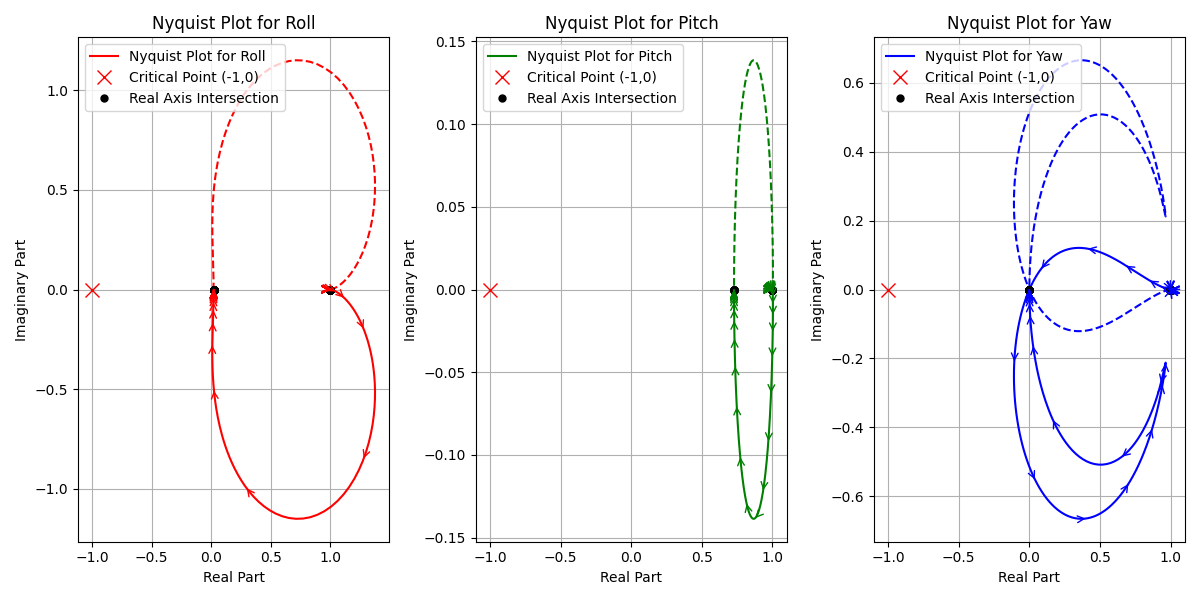

In [22]:
%matplotlib widget
import matplotlib.pyplot as plt
import control as ctrl
import numpy as np

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

# Titles for each subplot
titles = ['Nyquist Plot for Roll', 'Nyquist Plot for Pitch', 'Nyquist Plot for Yaw']

# Transfer functions for each axis
transfer_functions = [closed_loop_roll, closed_loop_pitch, closed_loop_yaw]
colors = ['red', 'green', 'blue']  # Colors for each plot
omega = np.logspace(-5, 5, 1000)  # From 0.001 to 1000 rad/s


for ax, tf, title, color in zip(axs, transfer_functions, titles, colors):
    # Compute frequency response
    mag, phase, omega = ctrl.freqresp(tf, omega)
    real = mag * np.cos(phase)
    imag = mag * np.sin(phase)
    
    # Plot Nyquist plot
    line, = ax.plot(real.squeeze(), imag.squeeze(), color=color, label=title)
    ax.plot(real.squeeze(), -imag.squeeze(), linestyle='--', color=color)  # Mirror image
    
    # Critical Point (-1, 0)
    ax.plot(-1, 0, 'rx', markersize=10, label='Critical Point (-1,0)')
    
    # Real Axis Intersections (Phase Crossover Points)
    # Find points where the imaginary part is close to zero
    real_axis_intersections = real.squeeze()[np.isclose(imag.squeeze(), 0, atol=1e-4)]
    for x in real_axis_intersections:
        ax.plot(x, 0, 'ko', markersize=5, label='Real Axis Intersection' if x == real_axis_intersections[0] else "")
    
    # Add arrows indicating direction of increasing frequency
    arrow_length = 0.5  # Length of the arrow
    for i in range(0, len(omega) - 1, 20):
        ax.annotate('', xy=(real[i + 1], imag[i + 1]), xytext=(real[i], imag[i]),
                    arrowprops=dict(arrowstyle='->', color=color),
                    size=12)
    
    ax.set_title(title)
    ax.set_xlabel('Real Part')
    ax.set_ylabel('Imaginary Part')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

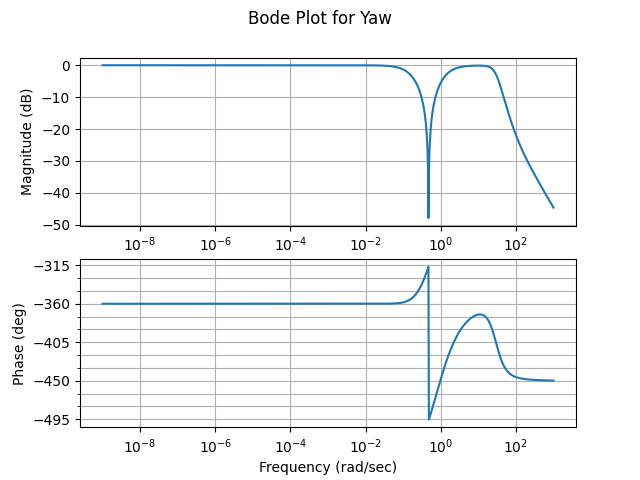

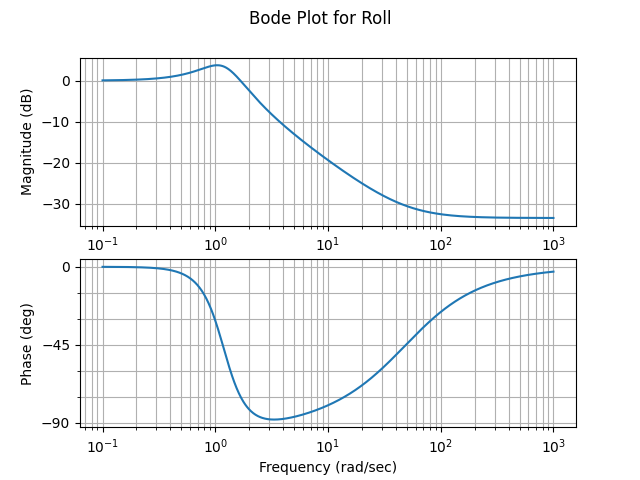

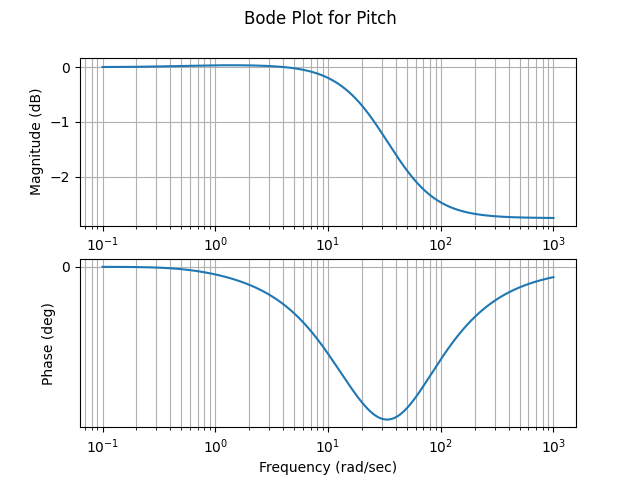

In [23]:

# Bode plot for Roll
plt.figure()
ctrl.bode_plot(closed_loop_roll, dB=True)
plt.suptitle('Bode Plot for Roll')

# Bode plot for Pitch
plt.figure()
ctrl.bode_plot(closed_loop_pitch, dB=True)
plt.suptitle('Bode Plot for Pitch')

# Bode plot for Yaw
plt.figure()
ctrl.bode_plot(closed_loop_yaw, dB=True)
plt.suptitle('Bode Plot for Yaw')

plt.show()

/tmp/ipykernel_4187/4142442655.py:2: UserWarning: indented contour may miss closed loop pole; consider reducing indent_radius to below     0
  ctrl.freqplot.nyquist_plot(closed_loop_pitch)
/tmp/ipykernel_4187/4142442655.py:2: UserWarning: number of encirclements does not match Nyquist criterion; check frequency range and indent radius/direction
  ctrl.freqplot.nyquist_plot(closed_loop_pitch)


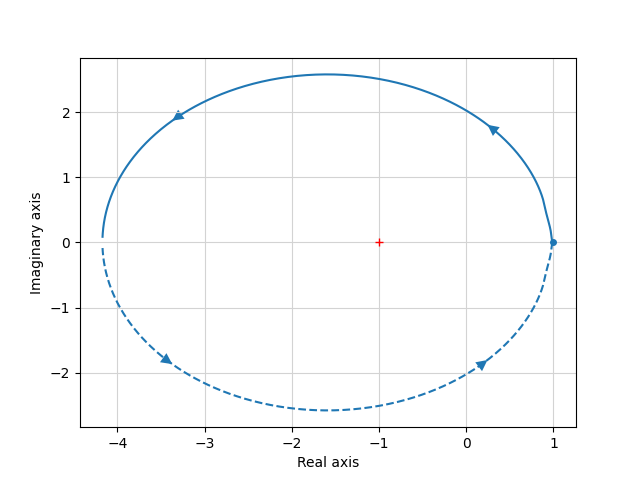

/tmp/ipykernel_4187/4142442655.py:6: UserWarning: indented contour may miss closed loop pole; consider reducing indent_radius to below     0
  ctrl.freqplot.nyquist_plot(closed_loop_roll)
/tmp/ipykernel_4187/4142442655.py:6: UserWarning: number of encirclements does not match Nyquist criterion; check frequency range and indent radius/direction
  ctrl.freqplot.nyquist_plot(closed_loop_roll)


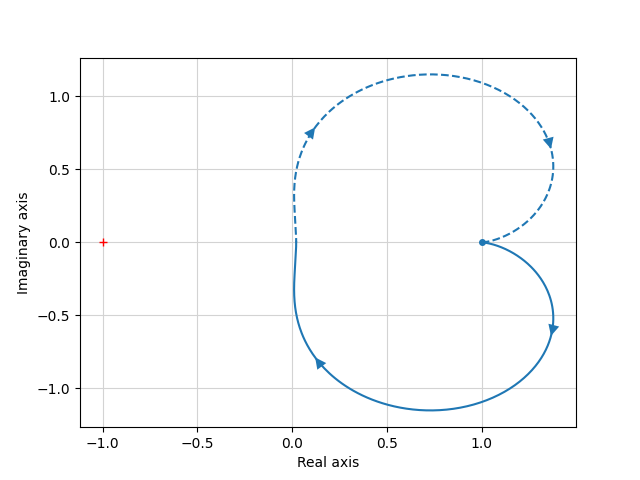

/tmp/ipykernel_4187/4142442655.py:10: UserWarning: indented contour may miss closed loop pole; consider reducing indent_radius to below 5.9e-09
  ctrl.freqplot.nyquist_plot(closed_loop_yaw)
/tmp/ipykernel_4187/4142442655.py:10: UserWarning: indented contour may miss closed loop pole; consider reducing indent_radius to below 7.3e-15
  ctrl.freqplot.nyquist_plot(closed_loop_yaw)


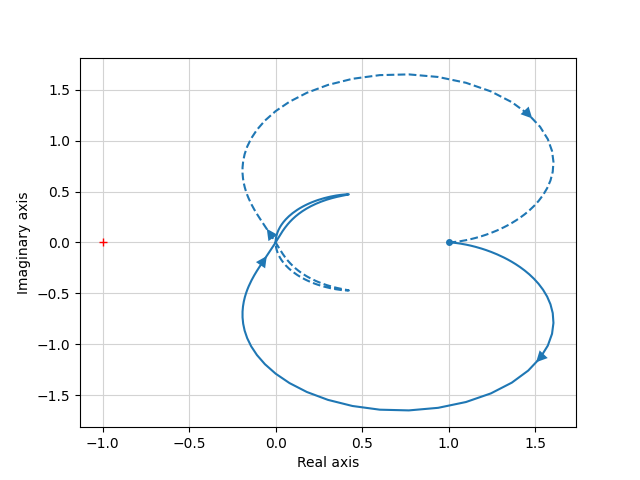

In [18]:
plt.figure()
ctrl.freqplot.nyquist_plot(closed_loop_pitch)
plt.show()

plt.figure()
ctrl.freqplot.nyquist_plot(closed_loop_roll)
plt.show()

plt.figure()
ctrl.freqplot.nyquist_plot(closed_loop_yaw)
plt.show()

/home/vince-cs/.local/lib/python3.12/site-packages/control/timeresp.py:1834: UserWarning: System has direct feedthrough: ``D != 0``. The infinite impulse at ``t=0`` does not appear in the output.
Results may be meaningless!
  warnings.warn("System has direct feedthrough: ``D != 0``. The "
/home/vince-cs/.local/lib/python3.12/site-packages/control/timeresp.py:1025: RuntimeWarning: overflow encountered in matmul
  xout[:, i] = expAdt @ xout[:, i-1]


[167.51830593+0.j          -9.43644657+9.85690371j
  -9.43644657-9.85690371j   9.38359093+9.04704235j
   9.38359093-9.04704235j  -0.49625962+0.j
   0.        +0.j           0.        +0.j
   0.        +0.j           0.        +0.j
   0.        +0.j        ]


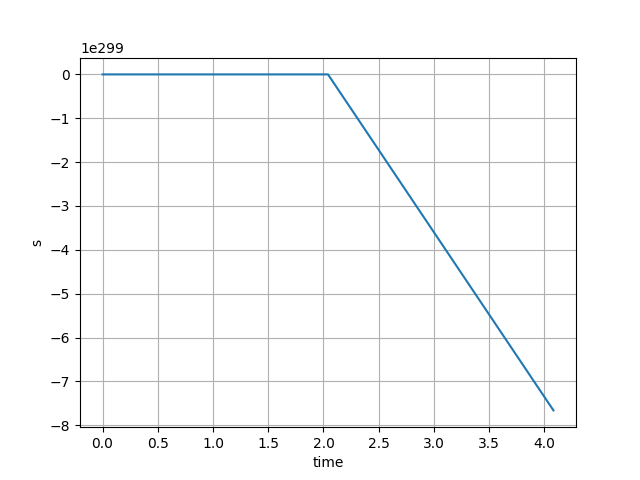

In [12]:
from control.matlab import rss, impulse
T = np.linspace(0,100)
response, T = impulse(closed_loop_pitch, T=T)

print(closed_loop_pitch.poles())
plt.figure()
plt.grid(True)
plt.plot(T, response)
plt.xlabel("time")
plt.ylabel("s")
plt.show()

# Etc

In [13]:
import numpy as np
from pydrake.all import LeafSystem, BasicVector, PortDataType, AbstractValue, Quaternion, RollPitchYaw
from pydrake.math import RotationMatrix
from pydrake.systems.framework import LeafSystem_, BasicVector_, PublishEvent, TriggerType
from pydrake.systems.scalar_conversion import TemplateSystem
from pydrake.symbolic import if_then_else, Expression
from pydrake.all import DiagramBuilder, Simulator, ConstantVectorSource
from pydrake.systems.primitives import LogVectorOutput


@TemplateSystem.define("QuaternionDynamicsSystem_")
def QuaternionDynamicsSystem_(T):

    class Impl(LeafSystem_[T]):

        def _construct(self, converter=None):
            LeafSystem_[T].__init__(self, converter)
            # Declare system state: assuming 10 states as per your dynamics
            self.DeclareContinuousState(10)
            # Input port for control inputs: assuming 4 inputs
            self.DeclareVectorInputPort("u", BasicVector_[T](4))
            # Output port for system state
            self.DeclareVectorOutputPort("x", BasicVector_[T](10), self.CopyStateOut)

        def _construct_copy(self, other, converter=None):
            # Constructor used for scalar conversion
            Impl._construct(self, converter=converter)

        def CopyStateOut(self, context, output):
            # Copy the state to the output port
            x = context.get_continuous_state_vector().CopyToVector()
            output.SetFromVector(x)

        def DoCalcTimeDerivatives(self, context, derivatives):
            x = context.get_continuous_state_vector().CopyToVector()
            u = self.EvalVectorInput(context, 0).CopyToVector()
            # Calculate dynamics here. Placeholder for actual dynamics calculation
            dx_dt = self.calculate_dynamics(x, u)
            derivatives.get_mutable_vector().SetFromVector(dx_dt)
    
        def calculate_dynamics(self, x, u):
            # Extract the state components
            p = x[:3]  # Position (px, py, pz)
            q = x[3:7]  # Orientation quaternion (qw, qx, qy, qz)
            v = x[7:]  # Velocity (vx, vy, vz)
        
            # Extract control inputs
            omega_des = u[:3]  # Desired body rates (wx_des, wy_des, wz_des)
            c_des = u[3]  # Desired thrust
        
            # Construct the quaternion from state
            q_w, q_x, q_y, q_z = q
        
            # Quaternion kinematics
            Qx = np.array([
                [ q_w, -q_x, -q_y, -q_z],
                [ q_x,  q_w, -q_z,  q_y],
                [ q_y,  q_z,  q_w, -q_x],
                [ q_z, -q_y,  q_x,  q_w]
            ])

            augmented_omega = np.concatenate(([0], omega_des)).reshape(4,)
            # Quaternion derivative
            q_dot = 0.5 * Qx @ augmented_omega
        
            # Compute the gravity vector
            g = 9.81  # Acceleration due to gravity
            g_vec = np.array([0, 0, -g])
        
            # Rotation matrix from quaternion
            R = np.array([
                [1 - 2*q_y**2 - 2*q_z**2, 2*q_x*q_y - 2*q_z*q_w,     2*q_x*q_z + 2*q_y*q_w],
                [2*q_x*q_y + 2*q_z*q_w,     1 - 2*q_x**2 - 2*q_z**2, 2*q_y*q_z - 2*q_x*q_w],
                [2*q_x*q_z - 2*q_y*q_w,     2*q_y*q_z + 2*q_x*q_w,     1 - 2*q_x**2 - 2*q_y**2]
            ])
        
            # Velocity dynamics
            v_dot = g_vec + R @ np.array([0, 0, c_des])
            dx_dt = np.concatenate((v, q_dot, v_dot))
        
            return dx_dt

    return Impl